In this notebook, we will explore how to use pytorch to build a neural network model to predict survivorship on Titanic. 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Loading the data

In [2]:
df = pd.read_csv("data/Titanic/train_processed.csv")
df.shape

(889, 10)

In [3]:
train_df = df[:int(0.8 * len(df))]
valid_df = df[int(0.8 * len(df)):]

In [4]:
len(train_df), len(valid_df)

(711, 178)

In [5]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,1
4,0,3,35.0,0,0,8.0500,0,0,0,1


## Define the model

Suppose we want to create a simple model with 1 middle layer that has 5 neurons. In pytorch, to create a model, we need to 
 - create a class that inherits nn.Module. 
 - the architecture (components) of the model will be defined in the constructor
 - the feed forward part needs to be defined in a function called forward. It tells how the data will flow through the network and how outputs are calculated

[Python class inheritance](https://www.w3schools.com/python/python_inheritance.asp)

In [6]:
class TitanicModel(nn.Module):
    def __init__(self): # self is equivalent to "this"
        super().__init__()
        # create a fc of 9 inputs and 5 outputs
        self.fc1 = nn.Linear(9, 5)
        self.dropout_layer = nn.Dropout(0.2)
        self.fc2 = nn.Linear(5, 2)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_layer(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [7]:
model = TitanicModel()

In [8]:
model.state_dict().keys()

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])

In [9]:
model.state_dict()['fc1.weight'].shape

torch.Size([5, 9])

As you can see, defining a model in pytorch is more complex compared to Scikit-learn. However this means there's more flexibility and freedom of how you define your models

## Loading the data into dataset and dataloader

Unlike scikit-learn where you can directly pass in pandas dataframe or numpy array into model training, we need to pass data into a dataset object then dataloader instead

To define our customized dataset, there are three requirements: 
- we will initialize the class with the content of the data
- we need to implement the len dunder function to tell pytorch how large our dataset is
- we need to implemnt the getitem function to tell pytorch how to get a piece of data

[Python Dunder methods](https://mathspp.com/blog/pydonts/dunder-methods#:~:text=In%20Python%2C%20dunder%20methods%20are,__%20or%20__add__%20.)

In [10]:
class TitanicDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        y = df['Survived'].values
        x = df.drop(['Survived'], axis=1).values
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return (len(self.y))
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [11]:
train_loader = torch.utils.data.DataLoader(TitanicDataset(train_df), batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(TitanicDataset(valid_df), batch_size=16, shuffle=False)

In PyTorch, the batch size is the number of samples that are processed by the model in one forward-backward pass. It is one of the hyperparameters that needs to be set when training a model with a DataLoader.

When the batch size is set to 1, the model processes one sample at a time, which is called online or stochastic training. When the batch size is set to the size of the entire dataset, the model processes the entire dataset in one forward-backward pass, which is called batch training. In practice, the batch size is usually set to a value between 1 and the size of the dataset, and is a trade-off between the accuracy of the gradient and the speed of training. A larger batch size can lead to faster training, but may also lead to a less accurate gradient.

For example, if you have a dataset of 100 samples and you set the batch size to 10, the DataLoader will return 10 samples at a time, and it will take 10 iterations to process the entire dataset.

It's important to note that the batch size can also affect the memory usage during the training and inference, as the model needs to hold all the batch data in memory. So it's important to choose a batch size that fits the amount of memory available.

In [12]:
# for i, (data, labels) in enumerate(train_loader):
#     print(data.shape, labels.shape)
#     print(data, labels)

## Define the training and validation process

In [13]:
train_losses = []
def train(model, train_loader, optimizer, epoch):
    model.train() #this sets the mode to training
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        optimizer.zero_grad() ## this is to ensure gradients from previous batch does not affect current batch
        output = model(data)
        
        loss = F.nll_loss(output, labels)
        train_loss += loss.item()
        loss.backward() ## calculate gradients
        optimizer.step() ## update the parameters using gradients
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Train Epoch: {epoch}, Loss: {train_loss: .6f}")

In [14]:
test_losses = []
def valid(model, test_loader):
    model.eval() # sets the mode to prediction
    test_loss = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, labels).item()
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"Test set average Loss: {test_loss: .6f}\n")

In [15]:
model = TitanicModel()

In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
for epoch in range(1, 20+1):
    train(model, train_loader, optimizer, epoch)
    valid(model, test_loader)

Train Epoch: 1, Loss:  0.093005
Test set average Loss:  0.072005

Train Epoch: 2, Loss:  0.060485
Test set average Loss:  0.055123

Train Epoch: 3, Loss:  0.047713
Test set average Loss:  0.047109

Train Epoch: 4, Loss:  0.043380
Test set average Loss:  0.043171

Train Epoch: 5, Loss:  0.042141
Test set average Loss:  0.041420

Train Epoch: 6, Loss:  0.041014
Test set average Loss:  0.040574

Train Epoch: 7, Loss:  0.040796
Test set average Loss:  0.040028

Train Epoch: 8, Loss:  0.040406
Test set average Loss:  0.039859

Train Epoch: 9, Loss:  0.039977
Test set average Loss:  0.039425

Train Epoch: 10, Loss:  0.039592
Test set average Loss:  0.039240

Train Epoch: 11, Loss:  0.040034
Test set average Loss:  0.039151

Train Epoch: 12, Loss:  0.040801
Test set average Loss:  0.039402

Train Epoch: 13, Loss:  0.039982
Test set average Loss:  0.039138

Train Epoch: 14, Loss:  0.040115
Test set average Loss:  0.039141

Train Epoch: 15, Loss:  0.040124
Test set average Loss:  0.039038

Trai

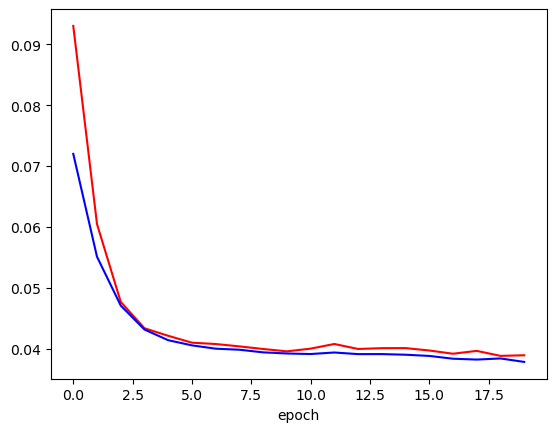

In [18]:
plt.plot(train_losses, color= 'r')
plt.plot(test_losses, color='b')
plt.xlabel("epoch")
plt.show()

In [ ]:
torch.manual_seed(23)